In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
%matplotlib inline

In [2]:
yelp = pd.read_csv("yelp_review_in_scope_dataset.csv")

In [3]:
yelp.shape

(199999, 9)

In [4]:
yelp.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",7/7/18 22:09
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,1/3/12 15:28
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2/5/14 20:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",1/4/15 0:01
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,1/14/17 20:54


In [5]:
yelp['text_length'] = yelp['text'].apply(len)
yelp.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",7/7/18 22:09,513
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,1/3/12 15:28,829
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2/5/14 20:30,339
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",1/4/15 0:01,243
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,1/14/17 20:54,534


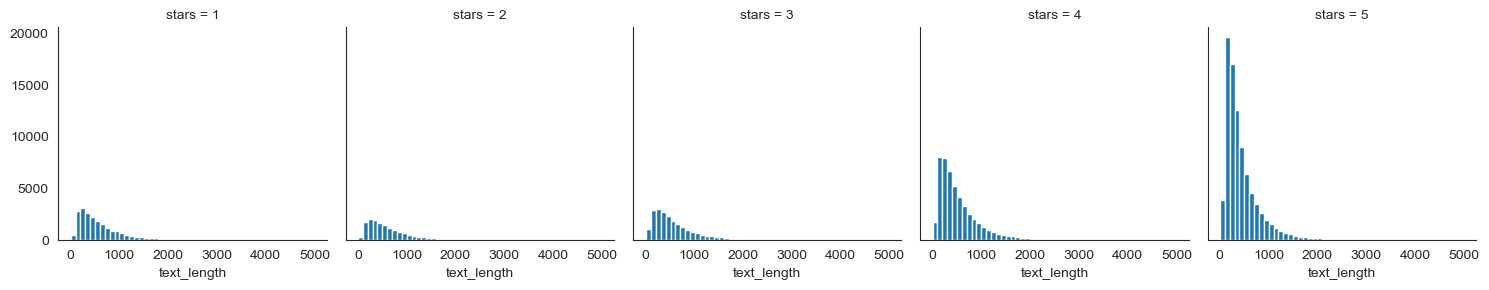

In [6]:
sns.set_style('white')
g = sns.FacetGrid(yelp, col = 'stars')
g.map(plt.hist, 'text_length', bins=50)

<Axes: xlabel='stars', ylabel='text_length'>

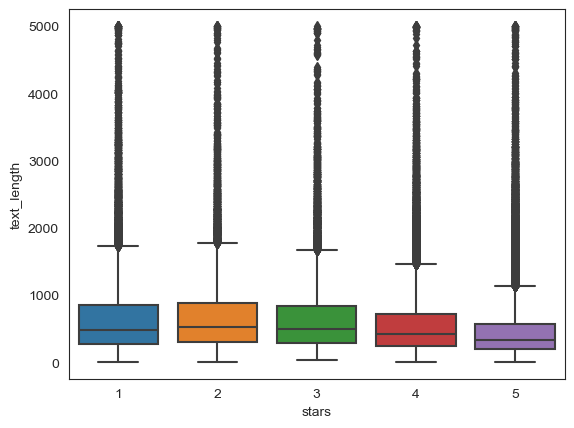

In [7]:
sns.boxplot(x='stars', y = 'text_length', data = yelp)

<Axes: xlabel='stars', ylabel='count'>

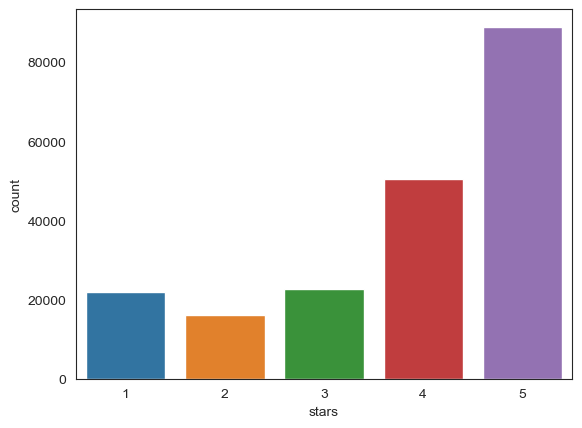

In [8]:
sns.countplot(x='stars', data=yelp)

In [9]:
stars = yelp.groupby('stars').mean(numeric_only=True)
stars

,useful,funny,cool,text_length
stars,,,,
1,1.427379,0.440106,0.152769,672.810236
2,1.136386,0.372921,0.216431,690.690308
3,0.845064,0.296318,0.314332,650.195161
4,0.841732,0.250045,0.446301,561.828732
5,0.778421,0.186214,0.375610,460.970775


In [10]:
stars.corr()

,useful,funny,cool,text_length
useful,1.000000,0.943876,-0.899971,0.691618
funny,0.943876,1.000000,-0.903259,0.889768
cool,-0.899971,-0.903259,1.000000,-0.745204
text_length,0.691618,0.889768,-0.745204,1.000000


<Axes: >

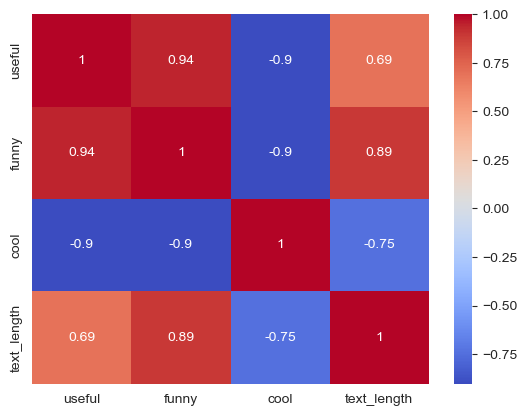

In [11]:
sns.heatmap(stars.corr(),cmap='coolwarm', annot=True)

In [12]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in set(stopwords.words('english'))]

    # Apply Porter Stemmer
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    preprocessed_text = ' '.join(stemmed_tokens)
    return preprocessed_text

Number of total samples: 3000

Support Vector Classifier Classifier (Based on Reviews):
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.78      0.85       104
           5       0.96      0.99      0.97       496

    accuracy                           0.95       600
   macro avg       0.95      0.88      0.91       600
weighted avg       0.95      0.95      0.95       600



Multinomial Naive Bayes Classifier (Based on Reviews):
Accuracy: 0.86
Precision: 0.87
Recall: 0.86
Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.18      0.31       104
           5       0.85      1.00      0.92       496

    accuracy                           0.86       600
   macro avg       0.90      0.59      0.61       600
weighted avg       0.87      0.86      0.81       600



Logistic Regression Classifier (Based on Reviews):
Accuracy: 0.

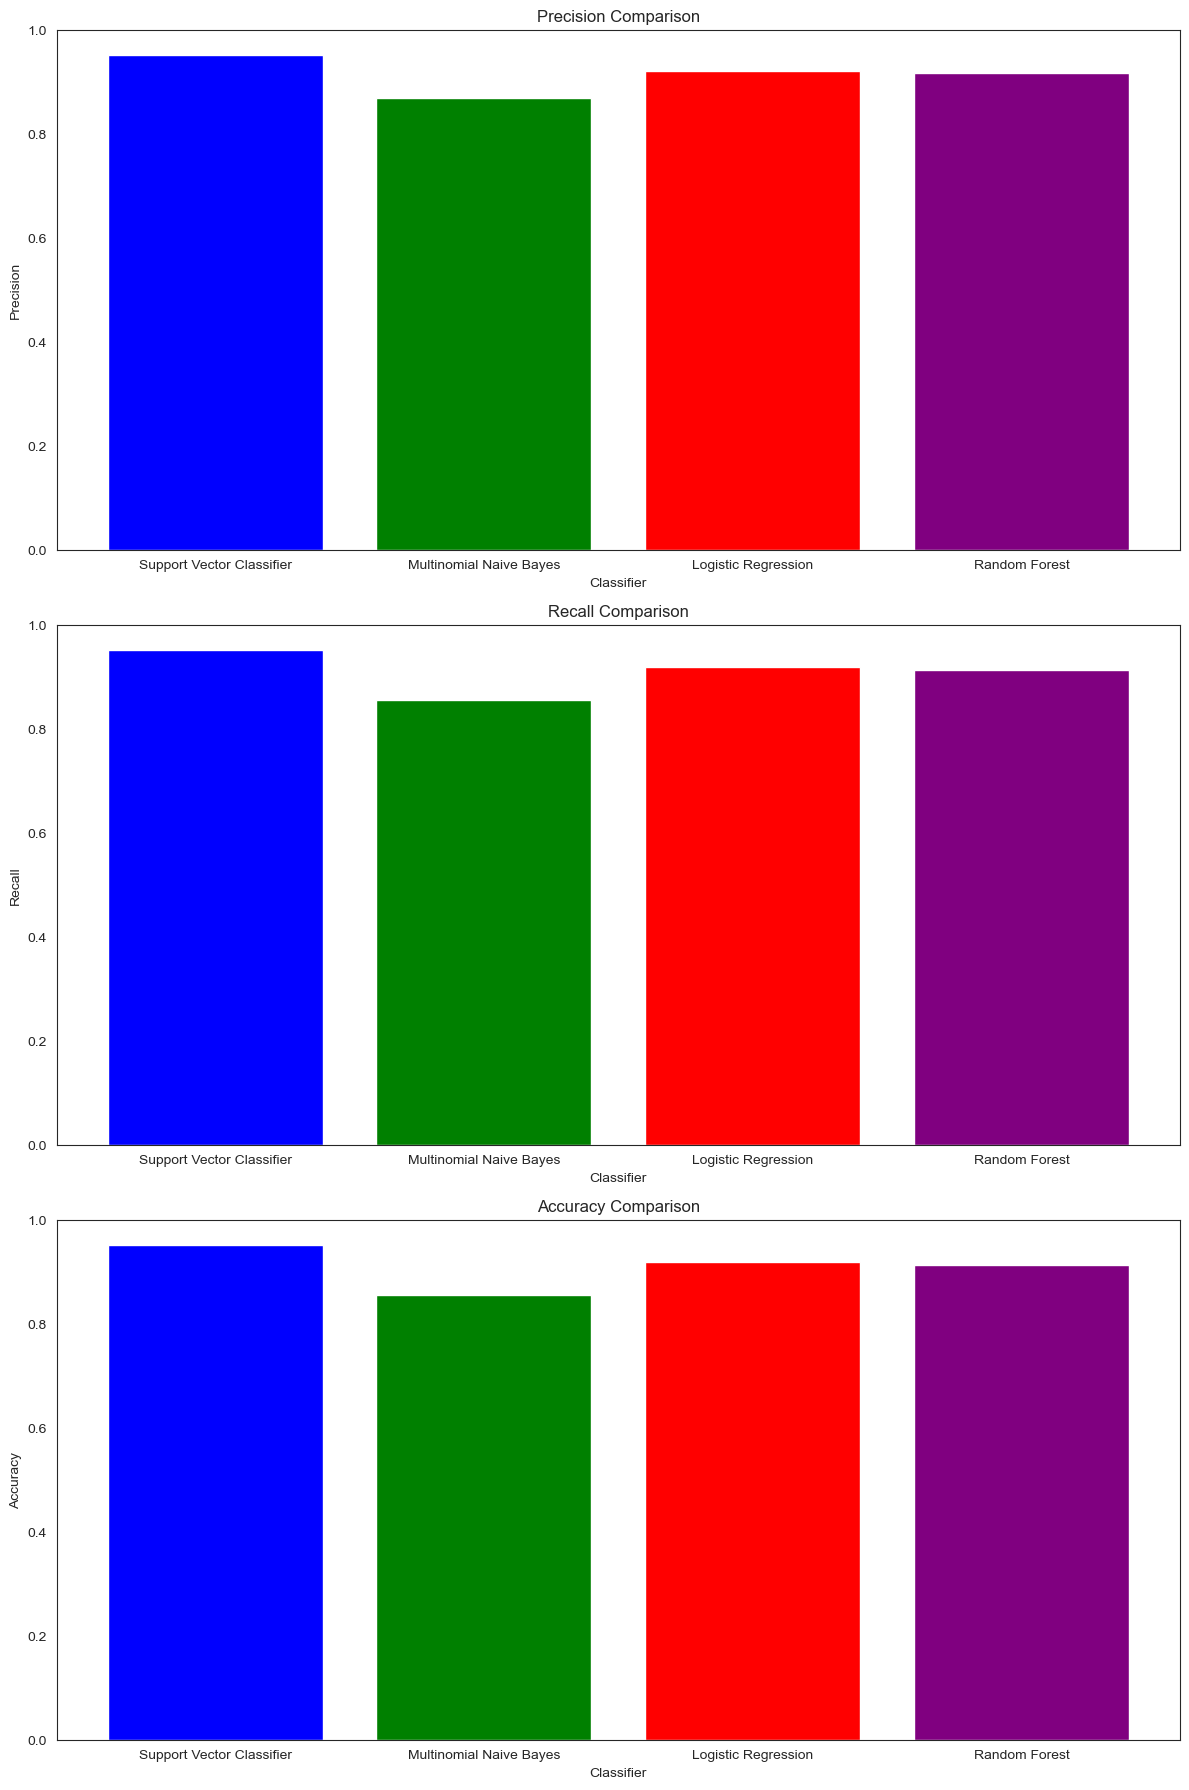

Support Vector Classifier Classifier Predictions (Based on Reviews):

Review:
 Horrible,  they have a scary mascot that scared my grandson and I asked him twice and my waitress for him not to come to our table.  Did he listen NO,kept coming back! Also served  a drink with a big crack! We will never return

Predicted Star Rating: 1

Actual Star Rating: 1

Review:
 Update after initial review:  ordered again last night using the yelp eat24 app. Food was ready within 10 minutes of placing the order. I opted for pickup since I was on my way home. The app did not give them my correct phone # and speaking to the great staff at the reception desk they told me sometimes yelp gets the addresses wrong for delivery so my advice is to type your phone # and address (if using delivery) into the comments box just so you get your food as fast as they intend to get it to you. 

This is the best place for sushi in the area. We have frequented other sushi places and this one by far stands above the rest.

In [13]:
# Take first 3000 rows
yelp_class = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)]
X = yelp_class['text'][:3000] 
y = yelp_class['stars'][:3000]
X = X.apply(preprocess_text)
print(f"Number of total samples: {len(X)}\n")

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers
classifiers = [
    ('Support Vector Classifier', SVC(kernel='linear', C=1)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier())
]

# Initialize lists to store metrics
precision_scores = []
recall_scores = []
accuracy_scores = []

# Train and evaluate each classifier
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    print(f"{name} Classifier (Based on Reviews):")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")

# Plot metrics in a bar chart
labels = [classifier[0] for classifier in classifiers]
metrics = ['Precision', 'Recall', 'Accuracy']

plt.figure(figsize=(12, 18))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    plt.bar(labels, [precision_scores[j] if metric == 'Precision' else recall_scores[j] if metric == 'Recall' else accuracy_scores[j] for j in range(len(classifiers))], color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title(f'{metric} Comparison')
    plt.xlabel('Classifier')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()
    
# Example unseen review texts for classification, First 3000 rows were already used for training and testing
new_reviews = yelp_class.iloc[3008:3010]["text"].to_numpy()
actual_star_ratings = yelp_class.iloc[3008:3010]["stars"].to_numpy()

# Preprocess the new reviews
new_reviews_processed = [preprocess_text(review) for review in new_reviews]

# Vectorize the new reviews using the same TF-IDF vectorizer
new_reviews_tfidf = tfidf_vectorizer.transform(new_reviews_processed)

# Predict the star ratings of the new reviews using each classifier based on 'reviews'
for name, clf in classifiers:
    star_ratings = clf.predict(new_reviews_tfidf)
    print(f"{name} Classifier Predictions (Based on Reviews):\n")
    for review, predicted_rating, actual_rating  in zip(new_reviews, star_ratings, actual_star_ratings):
        print(f"Review:\n {review}\n")
        print(f"Predicted Star Rating: {predicted_rating}\n")
        print(f"Actual Star Rating: {actual_rating}\n")
    print("\n")